In [64]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from scipy.stats import t
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader


## Define useful functions

In [65]:
def generateX(n):
    x = np.random.randn(n)*1.5
    return(x)

def generateNonlinearY(x, sigma):
    n = len(x)
    eps1 = np.random.gamma(2, 2, n) - 4
    eps2 = np.random.normal(0, .5, n)
    
    y = 2*np.maximum(x, 0) + sigma * ( (x + .5) * eps1 + eps2)
    return y

def splitData(x, y, n1):
    x1 = x[:n1]
    y1 = y[:n1]
    x2 = x[n1:]
    y2 = y[n1:]
    return x1, y1, x2, y2


## Define CQR interval function and residual interval function

In [66]:
def CQRInterval(scores, y_out_l_pred, y_out_u_pred, alpha):
    n = len(scores)
    t = np.quantile(scores, np.ceil((1-alpha)*(n+1))/n )
    y_out_l = y_out_l_pred - t
    y_out_u = y_out_u_pred + t 
    return np.hstack([y_out_l.reshape(-1, 1), y_out_u.reshape(-1, 1)])


def conformalResidueInterval(scores, mu, sigma, alpha):
    n = len(scores)
    t = np.quantile(scores, np.ceil((1-alpha)*(n+1))/n )
    y_out_l = mu - t*sigma
    y_out_u = mu + t*sigma
    return np.hstack([y_out_l.reshape(-1, 1), y_out_u.reshape(-1, 1)])

## Define neural network for quantile regression and heteroskedastic regression

In [67]:
class NNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2a = nn.Linear(hidden_dim, 1)
        self.layer2b = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        out1 = self.layer2a(x).squeeze()
        out2 = self.layer2b(x).squeeze()
        return out1, out2
    
    
def quantileLoss(y_out_l, y_out_u, y, alpha):
    lower_loss = torch.max( (alpha/2)*(y - y_out_l), (alpha/2-1)*(y - y_out_l) )
    upper_loss = torch.max( (1-alpha/2)*(y - y_out_u), (-alpha/2)*(y - y_out_u) )
    return torch.mean(lower_loss + upper_loss)

def heteroskedLoss(mu, log_nu, y):
    return torch.mean( (y - mu)**2 / (2*torch.exp(log_nu)**2) + log_nu )


## Experiment parameters

In [68]:
n = 2000
ntrain = 500

sigma = .2
alpha = 0.05 # 95% prediction interval for Y_new

# Experiment 1

### Generate data and train neural network for quantile regression

In [69]:

x = generateX(n) 
y = generateNonlinearY(x, sigma)

xtrain, ytrain, xtest, ytest = splitData(x, y, ntrain)

n1 = int(ntrain/2)
xtrain1, ytrain1, xtrain2, ytrain2 = splitData(xtrain, ytrain, n1)

## train neural network on first half of training data    
x_train1 = torch.tensor(xtrain1.reshape(-1, 1), dtype=torch.float32)
y_train1 = torch.tensor(ytrain1, dtype=torch.float32)

train_data = TensorDataset(x_train1, y_train1)
train_loader = DataLoader(dataset=train_data, batch_size=20, shuffle=True)

model = NNet(1, 10)
lr = 0.2
epochs = 150
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(epochs):

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_out_l, y_out_u = model(x_batch)
        loss = quantileLoss(y_out_l, y_out_u, y_batch, alpha)
        loss.backward()
        optimizer.step()

    if epoch % 20 == 0:
        print('epoch', epoch)


epoch 0


epoch 20
epoch 40
epoch 60
epoch 80
epoch 100
epoch 120
epoch 140


### Create CQR intervals

In [70]:

## compute non-conformity scores on second half of training data
## and prediction intervals on test data

x_train2 = torch.tensor(xtrain2.reshape(-1, 1), dtype=torch.float32)

y_out_l2, y_out_u2 = model(x_train2)
y_out_l2 = y_out_l2.detach().numpy()
y_out_u2 = y_out_u2.detach().numpy()

scores = np.maximum(ytrain2 - y_out_u2, y_out_l2 - ytrain2)

x_test = torch.tensor(xtest.reshape(-1, 1), dtype=torch.float32)
y_out_l_pred, y_out_u_pred = model(x_test)
y_out_l_pred = y_out_l_pred.detach().numpy()
y_out_u_pred = y_out_u_pred.detach().numpy()

intervals = CQRInterval(scores, y_out_l_pred, y_out_u_pred, alpha)

cov_test = [1 if ytest[i] >= intervals[i, 0] and ytest[i] <= intervals[i, 1] else 0 for i in range(len(ytest))]
print('Percent covered on test data: ', np.mean(cov_test))

Percent covered on test data:  0.96


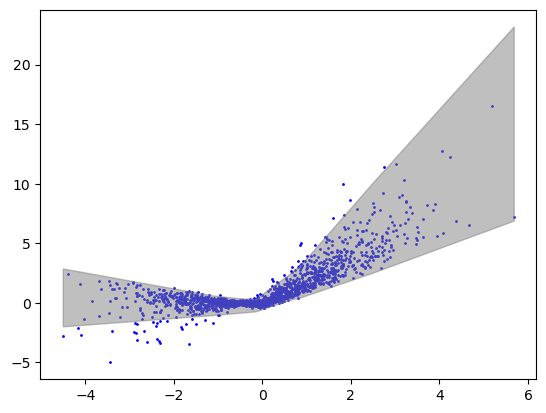

In [71]:
## plot prediction intervals
sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]
eps = np.random.randn(len(xgrid))

interval_grid = intervals[sorted_ix, :]
plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.fill_between(xgrid, interval_grid[:, 0], interval_grid[:, 1], color='gray', alpha=0.5, label='Prediction Interval')

# Experiment 2

### Generate same data and train neural network for heteroskedastic regression

In [76]:

x = generateX(n) 
y = generateNonlinearY(x, sigma)

xtrain, ytrain, xtest, ytest = splitData(x, y, ntrain)

n1 = int(ntrain/2)
xtrain1, ytrain1, xtrain2, ytrain2 = splitData(xtrain, ytrain, n1)

## train neural network on first half of training data    
x_train1 = torch.tensor(xtrain1.reshape(-1, 1), dtype=torch.float32)
y_train1 = torch.tensor(ytrain1, dtype=torch.float32)

train_data = TensorDataset(x_train1, y_train1)
train_loader = DataLoader(dataset=train_data, batch_size=20, shuffle=True)

model2 = NNet(1, 10)
lr = 0.2
epochs = 150
optimizer = optim.SGD(model2.parameters(), lr=lr)

for epoch in range(epochs):

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        mu, log_nu = model2(x_batch)
        loss = heteroskedLoss(mu, log_nu, y_batch)
        loss.backward()
        optimizer.step()

    if epoch % 20 == 0:
        print('epoch', epoch)


epoch 0
epoch 20
epoch 40
epoch 60
epoch 80
epoch 100
epoch 120
epoch 140


In [78]:

## compute non-conformity scores on second half of training data
## and prediction intervals on test data
x_train2 = torch.tensor(xtrain2.reshape(-1, 1), dtype=torch.float32)

mu_2, log_nu_2 = model2(x_train2)
mu_2 = mu_2.detach().numpy()
log_nu_2 = log_nu_2.detach().numpy()    
nu_2 = np.exp(log_nu_2)


scores = np.abs(ytrain2 - mu_2)/nu_2
##np.maximum(ytrain2 - y_out_u2, y_out_l2 - ytrain2)

x_test = torch.tensor(xtest.reshape(-1, 1), dtype=torch.float32)
mu_pred, log_nu_pred = model2(x_test)
mu_pred = mu_pred.detach().numpy()
log_nu_pred = log_nu_pred.detach().numpy()
nu_pred = np.exp(log_nu_pred)

intervals = conformalResidueInterval(scores, mu_pred, nu_pred, alpha)

cov_test = [1 if ytest[i] >= intervals[i, 0] and ytest[i] <= intervals[i, 1] else 0 for i in range(len(ytest))]
print('Percent covered on test data: ', np.mean(cov_test))

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

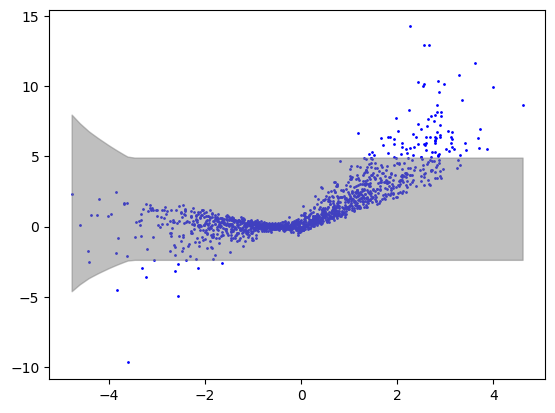

In [74]:
## plot prediction intervals
sorted_ix = np.argsort(xtest)
xgrid = xtest[sorted_ix]
ygrid = ytest[sorted_ix]
eps = np.random.randn(len(xgrid))

interval_grid = intervals[sorted_ix, :]
plt.scatter(xgrid, ygrid, color='blue', label='Data Points', s=1)
plt.fill_between(xgrid, interval_grid[:, 0], interval_grid[:, 1], color='gray', alpha=0.5, label='Prediction Interval')

([], [])

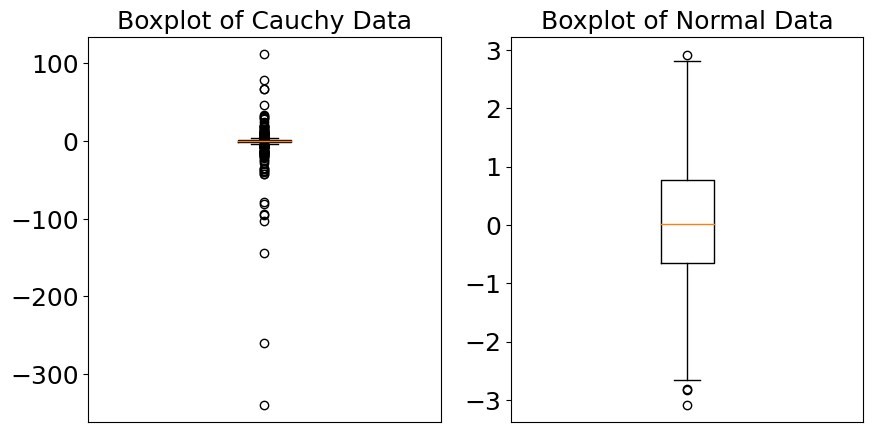

In [75]:
## generate cauchy data and plot boxplot

n = 1000
z = np.random.standard_cauchy(n)
x = np.random.normal(size=n)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.boxplot(z)
plt.title('Boxplot of Cauchy Data', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks([])

plt.subplot(1,2,2)
plt.boxplot(x)
plt.title('Boxplot of Normal Data', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks([])

#plt.tight_layout()
#plt.show()
